# 🔧 System Diagnostic - Run This First!

Before training, we need to verify that the GPU is properly accessible. This cell will check:
1. Slurm job allocation
2. GPU hardware detection
3. CUDA environment variables
4. PyTorch CUDA compatibility
5. Common issues and solutions

**Run the diagnostic cell below FIRST before proceeding with training!**

In [1]:
#!/usr/bin/env python3
"""
Comprehensive GPU Diagnostic for HPC Cluster
This cell diagnoses why PyTorch might show "device: cpu" even on GPU nodes
"""

import subprocess
import sys
import os

print("="*80)
print(" 🔍 COMPREHENSIVE GPU DIAGNOSTIC FOR HPC CLUSTER")
print("="*80)
print()

# ============================================================================
# 1. SLURM JOB INFORMATION
# ============================================================================
print("1️⃣  SLURM JOB ALLOCATION")
print("-" * 80)

slurm_vars = {
    'SLURM_JOB_ID': 'Job ID',
    'SLURM_JOB_NODELIST': 'Assigned Node(s)',
    'SLURM_NODEID': 'Node ID',
    'SLURM_GPUS': 'Total GPUs Allocated',
    'SLURM_GPUS_ON_NODE': 'GPUs on This Node',
    'SLURM_JOB_GPUS': 'GPU IDs Allocated',
    'SLURM_CPUS_ON_NODE': 'CPUs on Node',
    'SLURM_MEM_PER_NODE': 'Memory per Node',
}

slurm_allocated = False
for var, desc in slurm_vars.items():
    value = os.environ.get(var, 'NOT SET')
    print(f"  {desc:25s}: {value}")
    if var in ['SLURM_GPUS', 'SLURM_GPUS_ON_NODE', 'SLURM_JOB_GPUS']:
        if value != 'NOT SET' and value != '0' and value != '':
            slurm_allocated = True

print()
if slurm_allocated:
    print("  ✅ Slurm has allocated GPU(s) to this job")
else:
    print("  ⚠️  WARNING: No GPU allocation detected by Slurm!")
    print("     This job may not have requested GPU resources.")
    print()

# ============================================================================
# 2. CUDA ENVIRONMENT VARIABLES
# ============================================================================
print()
print("2️⃣  CUDA ENVIRONMENT VARIABLES")
print("-" * 80)

cuda_vars = {
    'CUDA_VISIBLE_DEVICES': 'Which GPUs are visible to CUDA',
    'CUDA_HOME': 'CUDA installation directory',
    'CUDA_PATH': 'CUDA path',
    'CUDA_ROOT': 'CUDA root directory',
    'LD_LIBRARY_PATH': 'Library path (includes CUDA libs)',
}

cuda_env_ok = False
for var, desc in cuda_vars.items():
    value = os.environ.get(var, 'NOT SET')
    if var == 'LD_LIBRARY_PATH' and value != 'NOT SET':
        # Show only CUDA-related parts
        cuda_parts = [p for p in value.split(':') if 'cuda' in p.lower() or 'CUDA' in p]
        if cuda_parts:
            print(f"  {var:25s}: {cuda_parts[0]} (and {len(cuda_parts)-1} more)")
        else:
            print(f"  {var:25s}: (no CUDA paths found)")
    else:
        print(f"  {var:25s}: {value}")
    
    if var == 'CUDA_VISIBLE_DEVICES' and value != 'NOT SET':
        cuda_env_ok = True

print()
if cuda_env_ok:
    print("  ✅ CUDA_VISIBLE_DEVICES is set")
else:
    print("  ⚠️  WARNING: CUDA_VISIBLE_DEVICES not set!")
    print("     GPUs may not be visible to applications.")
    print()

# ============================================================================
# 3. GPU HARDWARE DETECTION (nvidia-smi)
# ============================================================================
print()
print("3️⃣  GPU HARDWARE DETECTION (nvidia-smi)")
print("-" * 80)

try:
    result = subprocess.run(
        ['nvidia-smi', '--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free',
         '--format=csv'],
        capture_output=True, text=True, timeout=5
    )
    
    if result.returncode == 0:
        print(result.stdout)
        print("  ✅ GPU hardware detected successfully")
        hardware_ok = True
    else:
        print(f"  ❌ nvidia-smi failed with error:\n{result.stderr}")
        hardware_ok = False
except FileNotFoundError:
    print("  ❌ nvidia-smi command not found!")
    print("     GPU drivers may not be installed.")
    hardware_ok = False
except Exception as e:
    print(f"  ❌ Error running nvidia-smi: {e}")
    hardware_ok = False

print()

# ============================================================================
# 4. CUDA TOOLKIT VERSION
# ============================================================================
print("4️⃣  CUDA TOOLKIT VERSION")
print("-" * 80)

try:
    result = subprocess.run(['nvcc', '--version'], capture_output=True, text=True, timeout=5)
    if result.returncode == 0:
        for line in result.stdout.split('\n'):
            if 'release' in line.lower():
                print(f"  System CUDA: {line.strip()}")
                # Extract version number
                import re
                match = re.search(r'release (\d+\.\d+)', line)
                if match:
                    cuda_version = match.group(1)
                    print(f"  CUDA Version: {cuda_version}")
    else:
        print("  ⚠️  nvcc not found (CUDA toolkit may not be in PATH)")
except Exception as e:
    print(f"  ⚠️  Could not determine CUDA version: {e}")

print()

# ============================================================================
# 5. PYTORCH CUDA DETECTION
# ============================================================================
print("5️⃣  PYTORCH CUDA DETECTION")
print("-" * 80)

try:
    import torch
    print(f"  PyTorch Version: {torch.__version__}")
    print(f"  PyTorch Built with CUDA: {torch.version.cuda}")
    print(f"  CUDA Available: {torch.cuda.is_available()}")
    
    if torch.cuda.is_available():
        print(f"  CUDA Device Count: {torch.cuda.device_count()}")
        for i in range(torch.cuda.device_count()):
            print(f"    GPU {i}: {torch.cuda.get_device_name(i)}")
            props = torch.cuda.get_device_properties(i)
            print(f"      Total Memory: {props.total_memory / 1024**3:.2f} GB")
        print()
        print("  ✅ PyTorch can access GPU(s)!")
        pytorch_ok = True
    else:
        print()
        print("  ❌ PyTorch CANNOT access GPU!")
        pytorch_ok = False
        
        # Diagnose why
        print()
        print("  🔍 DIAGNOSIS:")
        
        # Check CUDA version mismatch
        if torch.version.cuda:
            pytorch_cuda = torch.version.cuda
            print(f"     - PyTorch was built for CUDA {pytorch_cuda}")
            
            # Try to get system CUDA version
            try:
                nvcc_result = subprocess.run(['nvcc', '--version'], capture_output=True, text=True, timeout=5)
                if nvcc_result.returncode == 0:
                    import re
                    match = re.search(r'release (\d+\.\d+)', nvcc_result.stdout)
                    if match:
                        system_cuda = match.group(1)
                        print(f"     - System has CUDA {system_cuda}")
                        
                        # Compare major versions
                        pytorch_major = pytorch_cuda.split('.')[0]
                        system_major = system_cuda.split('.')[0]
                        
                        if pytorch_major != system_major:
                            print()
                            print(f"     ⚠️  CUDA VERSION MISMATCH!")
                            print(f"         PyTorch needs CUDA {pytorch_major}.x")
                            print(f"         System has CUDA {system_major}.x")
                            print()
                            print(f"     💡 SOLUTION: Reinstall PyTorch with CUDA {system_major}.x support")
                            if system_major == '11':
                                print(f"         pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118")
                            elif system_major == '12':
                                print(f"         pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121")
            except:
                pass
        
        # Check if CUDA_VISIBLE_DEVICES is set
        if os.environ.get('CUDA_VISIBLE_DEVICES') == '':
            print("     - CUDA_VISIBLE_DEVICES is empty (no GPUs visible)")
        elif os.environ.get('CUDA_VISIBLE_DEVICES') is None:
            print("     - CUDA_VISIBLE_DEVICES is not set")
        
        # Check if Slurm allocated GPU
        if not slurm_allocated:
            print("     - Slurm did not allocate GPU to this job")
            print("       Did you request GPU with --gres=gpu:1?")

except ImportError:
    print("  ❌ PyTorch is not installed!")
    pytorch_ok = False

print()

# ============================================================================
# 6. PYTHON ENVIRONMENT INFORMATION
# ============================================================================
print("6️⃣  PYTHON ENVIRONMENT")
print("-" * 80)

print(f"  Python Version: {sys.version}")
print(f"  Python Executable: {sys.executable}")
print(f"  Python Prefix: {sys.prefix}")
print()

# Check if we're in a virtual environment
in_venv = hasattr(sys, 'real_prefix') or (hasattr(sys, 'base_prefix') and sys.base_prefix != sys.prefix)
in_conda = os.path.exists(os.path.join(sys.prefix, 'conda-meta'))

if in_conda:
    print("  ✅ Running in Conda environment")
    conda_env = os.environ.get('CONDA_DEFAULT_ENV', 'unknown')
    print(f"  Conda Environment: {conda_env}")
elif in_venv:
    print("  ✅ Running in virtual environment")
else:
    print("  ⚠️  Running in system Python (not recommended)")

print()

# ============================================================================
# 7. CONDA INFORMATION (if applicable)
# ============================================================================
if in_conda:
    print("7️⃣  CONDA INFORMATION")
    print("-" * 80)
    
    try:
        result = subprocess.run(['conda', '--version'], capture_output=True, text=True, timeout=5)
        if result.returncode == 0:
            print(f"  Conda Version: {result.stdout.strip()}")
    except:
        print("  ⚠️  Could not determine conda version")
    
    try:
        result = subprocess.run(['conda', 'info', '--envs'], capture_output=True, text=True, timeout=10)
        if result.returncode == 0:
            print("\n  Available Conda Environments:")
            for line in result.stdout.split('\n'):
                if line.strip() and not line.startswith('#'):
                    print(f"    {line}")
    except:
        print("  ⚠️  Could not list conda environments")
    
    print()

# ============================================================================
# 8. INSTALLED PACKAGES DIAGNOSTICS
# ============================================================================
print("8️⃣  INSTALLED PACKAGES (KEY LIBRARIES)")
print("-" * 80)

key_packages = [
    'torch',
    'torchvision',
    'torchaudio',
    'numpy',
    'transformers',
    'diffusers',
    'accelerate',
    'datasets',
    'pillow',
    'matplotlib',
]

installed_packages = {}
missing_packages = []

for package_name in key_packages:
    try:
        if package_name == 'pillow':
            import PIL
            installed_packages[package_name] = PIL.__version__
        else:
            pkg = __import__(package_name)
            version = getattr(pkg, '__version__', 'unknown')
            installed_packages[package_name] = version
    except ImportError:
        missing_packages.append(package_name)

print("  Installed:")
for pkg, version in installed_packages.items():
    print(f"    ✅ {pkg:20s}: {version}")

if missing_packages:
    print("\n  Missing:")
    for pkg in missing_packages:
        print(f"    ❌ {pkg}")

print()

# ============================================================================
# 9. PIP PACKAGE LIST (FULL)
# ============================================================================
print("9️⃣  ALL INSTALLED PIP PACKAGES")
print("-" * 80)

try:
    result = subprocess.run([sys.executable, '-m', 'pip', 'list'], 
                          capture_output=True, text=True, timeout=30)
    if result.returncode == 0:
        lines = result.stdout.split('\n')
        # Show first 50 packages to avoid excessive output
        print("  (Showing first 50 packages, use 'pip list' to see all)")
        print()
        for i, line in enumerate(lines[:52]):  # 2 header lines + 50 packages
            if line.strip():
                print(f"  {line}")
        if len(lines) > 52:
            print(f"  ... and {len(lines) - 52} more packages")
    else:
        print("  ⚠️  Could not retrieve pip package list")
except Exception as e:
    print(f"  ⚠️  Error retrieving pip packages: {e}")

print()

# ============================================================================
# 10. PYTORCH INSTALLATION DIAGNOSTICS
# ============================================================================
print("🔟 PYTORCH INSTALLATION DIAGNOSTICS")
print("-" * 80)

if 'torch' in installed_packages:
    print("  PyTorch is installed but CUDA not available")
    print()
    print("  Possible causes:")
    print("    1. PyTorch installed without CUDA support (CPU-only version)")
    print("    2. PyTorch CUDA version doesn't match system CUDA")
    print()
    
    # Try to determine which PyTorch was installed
    try:
        result = subprocess.run(
            [sys.executable, '-m', 'pip', 'show', 'torch'],
            capture_output=True, text=True, timeout=10
        )
        if result.returncode == 0:
            print("  PyTorch installation details:")
            for line in result.stdout.split('\n'):
                if any(key in line for key in ['Version:', 'Location:', 'Requires:']):
                    print(f"    {line}")
    except:
        pass
    
    print()
    print("  💡 RECOMMENDED FIX:")
    print("     Reinstall PyTorch with CUDA 11.8 support:")
    print()
    print("     pip uninstall torch torchvision torchaudio -y")
    print("     pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118")
else:
    print("  PyTorch is NOT installed")
    print()
    print("  💡 RECOMMENDED FIX:")
    print("     Install PyTorch with CUDA 11.8 support:")
    print()
    print("     pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118")

print()

# ============================================================================
# 11. JUPYTER KERNEL INFORMATION
# ============================================================================
print("1️⃣1️⃣  JUPYTER KERNEL INFORMATION")
print("-" * 80)

# Get kernel name from IPython
try:
    from IPython import get_ipython
    ipython = get_ipython()
    if ipython is not None:
        # Try to get kernel info
        kernel_name = 'unknown'
        try:
            # Check if running in Jupyter
            if hasattr(ipython, 'kernel'):
                kernel_name = getattr(ipython.kernel, 'kernel_info', {}).get('name', 'unknown')
        except:
            pass
        
        # Try alternative method - check connection file
        try:
            connection_file = ipython.config.get('IPKernelApp', {}).get('connection_file', '')
            if connection_file:
                print(f"  Connection File: {os.path.basename(connection_file)}")
        except:
            pass
        
        print(f"  IPython Session: {ipython.__class__.__name__}")
    else:
        print("  IPython Session: Not running in IPython")
except Exception as e:
    print(f"  IPython Detection: {e}")

kernel_info = {
    'Jupyter Runtime': os.environ.get('JUPYTER_RUNTIME_DIR', 'NOT SET'),
    'Kernel ID': os.environ.get('KERNEL_ID', 'NOT SET'),
}

for key, value in kernel_info.items():
    print(f"  {key:20s}: {value}")

print()
print(f"  Python Interpreter: {sys.executable}")

# Check if kernel matches conda environment
if in_conda:
    conda_env = os.environ.get('CONDA_DEFAULT_ENV', 'unknown')
    kernel_python = sys.executable
    print(f"  Current Conda Env: {conda_env}")
    print(f"  Kernel Python Path: {kernel_python}")
    
    if conda_env not in kernel_python and conda_env != 'base':
        print()
        print("  ⚠️  WARNING: Jupyter kernel may not be using the correct conda environment!")
        print(f"     You may need to install ipykernel in the '{conda_env}' environment:")
        print(f"     conda activate {conda_env}")
        print(f"     conda install ipykernel")
        print(f"     python -m ipykernel install --user --name={conda_env}")

print()

# ============================================================================
# 12. SUMMARY & RECOMMENDATIONS
# ============================================================================
print("="*80)
print(" 📋 SUMMARY & RECOMMENDATIONS")
print("="*80)
print()

all_checks = {
    'Slurm GPU Allocation': slurm_allocated,
    'CUDA Environment': cuda_env_ok,
    'GPU Hardware (nvidia-smi)': hardware_ok,
    'PyTorch CUDA Access': pytorch_ok,
}

for check, status in all_checks.items():
    status_icon = "✅" if status else "❌"
    print(f"  {status_icon} {check}")

print()

if all(all_checks.values()):
    print("🎉 ALL CHECKS PASSED! GPU is ready for training.")
else:
    print("⚠️  ISSUES DETECTED. Review the diagnostic output above.")
    print()
    print("Common solutions:")
    print()
    print("1. If 'Slurm GPU Allocation' failed:")
    print("   - Make sure you started Jupyter with: bash slurm/start_jupyter.sh gpu7")
    print("   - Check job allocation: squeue -u $USER")
    print()
    print("2. If 'PyTorch CUDA Access' failed but hardware is OK:")
    print("   - Most likely PyTorch not installed or wrong CUDA version")
    print("   - See section 10 above for installation commands")
    print()
    print("3. If 'GPU Hardware' failed:")
    print("   - Job may be on a CPU-only node")
    print("   - Cancel and restart with: bash slurm/start_jupyter.sh gpu7")
    print()
    print("4. If kernel/environment mismatch:")
    print("   - See section 11 above for kernel installation commands")

print()
print("="*80)

 🔍 COMPREHENSIVE GPU DIAGNOSTIC FOR HPC CLUSTER

1️⃣  SLURM JOB ALLOCATION
--------------------------------------------------------------------------------
  Job ID                   : 3032765
  Assigned Node(s)         : gpu2
  Node ID                  : 0
  Total GPUs Allocated     : NOT SET
  GPUs on This Node        : 2
  GPU IDs Allocated        : 0,1
  CPUs on Node             : 2
  Memory per Node          : 16384

  ✅ Slurm has allocated GPU(s) to this job

2️⃣  CUDA ENVIRONMENT VARIABLES
--------------------------------------------------------------------------------
  CUDA_VISIBLE_DEVICES     : 0,1
  CUDA_HOME                : /prefix/software/CUDA/11.8.0
  CUDA_PATH                : /prefix/software/CUDA/11.8.0
  CUDA_ROOT                : /prefix/software/CUDA/11.8.0
  LD_LIBRARY_PATH          : /prefix/software/CUDA/11.8.0/nvvm/lib64 (and 2 more)

  ✅ CUDA_VISIBLE_DEVICES is set

3️⃣  GPU HARDWARE DETECTION (nvidia-smi)
-----------------------------------------------------

/home/doshlom4/work/conda/envs/shlomid_conda_12_11_2025/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


  Installed:
    ✅ torch               : 2.7.1+cu118
    ✅ torchvision         : 0.22.1+cu118
    ✅ torchaudio          : 2.7.1+cu118
    ✅ numpy               : 2.2.5
    ✅ transformers        : 4.57.1
    ✅ diffusers           : 0.35.2
    ✅ accelerate          : 1.11.0
    ✅ datasets            : 4.4.1
    ✅ pillow              : 12.0.0
    ✅ matplotlib          : 3.10.7

9️⃣  ALL INSTALLED PIP PACKAGES
--------------------------------------------------------------------------------
  (Showing first 50 packages, use 'pip list' to see all)

  Package                   Version
  ------------------------- ------------
  accelerate                1.11.0
  aiohappyeyeballs          2.6.1
  aiohttp                   3.13.2
  aiosignal                 1.4.0
  anyio                     4.11.0
  argon2-cffi               25.1.0
  argon2-cffi-bindings      25.1.0
  arrow                     1.4.0
  asttokens                 3.0.0
  async-lru                 2.0.5
  async-timeout             5

# 🎨 Flickr8k Text-to-Image Inference

This notebook loads a trained checkpoint and generates images from text prompts with different guidance scales.

## Features
- Load latest checkpoint automatically
- Generate images from custom text prompts
- Test multiple guidance scales (0 to 15)
- High-quality 256x256 image generation

## 1. Imports and Setup

In [2]:
from __future__ import annotations

import os
from dataclasses import dataclass
from typing import Optional

import numpy as np
import torch
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

from diffusers import DDPMScheduler
from diffusers.models import AutoencoderKL
from diffusers.models.unets.unet_2d_condition import UNet2DConditionModel

from transformers import CLIPTextModel, CLIPTokenizer

## 2. Configuration

In [3]:
@dataclass
class InferenceConfig:
    checkpoint_dir: str = "./outputs/train12_flickr8k_text2img"
    image_size: int = 256
    seed: int = 42
    # UNet size (must match training)
    unet_block_out_channels: tuple[int, ...] = (128, 256, 512, 512)
    layers_per_block: int = 2


config = InferenceConfig()

def get_device() -> torch.device:
    if torch.cuda.is_available():
        return torch.device("cuda")
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

device = get_device()
print(f"Using device: {device}")

Using device: cuda


## 3. Load Models

In [4]:
print("Loading pretrained VAE...")
vae = AutoencoderKL.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="vae")
vae.requires_grad_(False)
vae.eval()
vae.to(device)

print("Loading CLIP text encoder...")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
text_encoder.requires_grad_(False)
text_encoder.eval()
text_encoder.to(device)

print("Creating UNet2DConditionModel...")
unet = UNet2DConditionModel(
    sample_size=config.image_size // 8,
    in_channels=4,
    out_channels=4,
    layers_per_block=config.layers_per_block,
    block_out_channels=config.unet_block_out_channels,
    down_block_types=(
        "DownBlock2D",
        "CrossAttnDownBlock2D",
        "CrossAttnDownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "CrossAttnUpBlock2D",
        "CrossAttnUpBlock2D",
        "UpBlock2D",
    ),
    cross_attention_dim=512,
).to(device)

num_params = sum(p.numel() for p in unet.parameters())
print(f"UNet parameters: {num_params:,}")

Loading pretrained VAE...
Loading CLIP text encoder...
Creating UNet2DConditionModel...
UNet parameters: 137,372,932


## 4. Load Latest Checkpoint

In [5]:
def find_latest_checkpoint(output_dir: str):
    """Find the latest checkpoint in the output directory."""
    if not os.path.exists(output_dir):
        return None
    
    checkpoint_files = []
    for filename in os.listdir(output_dir):
        if filename.endswith('.pt') and (filename.startswith('unet_step_') or 
                                         filename.startswith('unet_epoch_') or
                                         filename == 'unet_final.pt'):
            filepath = os.path.join(output_dir, filename)
            checkpoint_files.append(filepath)
    
    if not checkpoint_files:
        return None
    
    latest_checkpoint = max(checkpoint_files, key=os.path.getmtime)
    return latest_checkpoint


# Find and load checkpoint
checkpoint_path = find_latest_checkpoint(config.checkpoint_dir)

if checkpoint_path is None:
    raise FileNotFoundError(f"No checkpoint found in {config.checkpoint_dir}")

print(f"Loading checkpoint: {checkpoint_path}")
checkpoint = torch.load(checkpoint_path, map_location=device)

if isinstance(checkpoint, dict):
    if 'unet' in checkpoint:
        unet.load_state_dict(checkpoint['unet'])
        print(f"Loaded checkpoint from step {checkpoint.get('global_step', 'unknown')}, epoch {checkpoint.get('epoch', 'unknown')}")
    else:
        unet.load_state_dict(checkpoint)
else:
    unet.load_state_dict(checkpoint)

unet.eval()
print("✅ Checkpoint loaded successfully!")

Loading checkpoint: ./outputs/train12_flickr8k_text2img/unet_step_67500.pt
Loaded checkpoint from step 67500, epoch 34
✅ Checkpoint loaded successfully!


## 5. Text Encoding Helper

In [6]:
def encode_text(text: str, tokenizer, text_encoder, device):
    """Encode text prompt into embeddings using CLIP."""
    text_inputs = tokenizer(
        text,
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )
    text_input_ids = text_inputs.input_ids.to(device)
    
    with torch.no_grad():
        text_embeddings = text_encoder(text_input_ids)[0]
    
    return text_embeddings

## 6. Image Generation Function

In [7]:
@torch.no_grad()
def generate_image(
    prompt: str,
    num_inference_steps: int = 50,
    guidance_scale: float = 7.5,
    seed: Optional[int] = None,
):
    """Generate an image from a text prompt.
    
    Args:
        prompt: Text description of the image to generate
        num_inference_steps: Number of denoising steps (higher = better quality, slower)
        guidance_scale: Classifier-free guidance scale (higher = more prompt adherence)
        seed: Random seed for reproducibility
    
    Returns:
        Generated image tensor [1, 3, H, W] in range [0, 1]
    """
    if seed is not None:
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)

    # Create scheduler
    scheduler = DDPMScheduler(beta_schedule="squaredcos_cap_v2", num_train_timesteps=1000)
    scheduler.set_timesteps(num_inference_steps)

    # Encode text prompt
    text_embeddings = encode_text(prompt, tokenizer, text_encoder, device)
    
    # For classifier-free guidance, also encode empty prompt
    if guidance_scale > 1.0:
        uncond_embeddings = encode_text("", tokenizer, text_encoder, device)
        text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Initialize random latents
    latents = torch.randn((1, 4, config.image_size // 8, config.image_size // 8), device=device)

    # Denoising loop
    for t in tqdm(scheduler.timesteps, desc=f"Generating (guidance={guidance_scale})"):
        # Prepare latent input
        latent_model_input = latents
        if guidance_scale > 1.0:
            latent_model_input = torch.cat([latents] * 2)
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # Predict noise
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # Perform classifier-free guidance
        if guidance_scale > 1.0:
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # Step
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    # Decode latents to image
    latents = latents / 0.18215
    image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.cpu()

    return image

## 7. Generate Images with Different Guidance Scales

**Customize your prompt below!**

In [8]:
# ============================================================================
# CUSTOMIZE YOUR PROMPT HERE
# ============================================================================
prompt = "A dog"

# Different guidance scales to test
guidance_scales = [0, 3, 5, 7.5, 10, 15]

# Number of denoising steps (higher = better quality but slower)
num_inference_steps = 50

# Random seed for reproducibility
seed = 42
# ============================================================================

print(f"Prompt: '{prompt}'")
print(f"Guidance scales: {guidance_scales}")
print(f"Inference steps: {num_inference_steps}")
print(f"Seed: {seed}")
print("\n" + "="*80)

# Generate images
generated_images = []
for gs in guidance_scales:
    print(f"\nGenerating with guidance scale {gs}...")
    image = generate_image(
        prompt=prompt,
        guidance_scale=gs,
        num_inference_steps=num_inference_steps,
        seed=seed,
    )
    generated_images.append(image)

print("\n" + "="*80)
print("✅ All images generated!")

Prompt: 'A dog'
Guidance scales: [0, 3, 5, 7.5, 10, 15]
Inference steps: 50
Seed: 42


Generating with guidance scale 0...


Generating (guidance=0): 100%|██████████| 50/50 [00:03<00:00, 15.39it/s]



Generating with guidance scale 3...


Generating (guidance=3): 100%|██████████| 50/50 [00:02<00:00, 21.08it/s]



Generating with guidance scale 5...


Generating (guidance=5): 100%|██████████| 50/50 [00:02<00:00, 21.59it/s]



Generating with guidance scale 7.5...


Generating (guidance=7.5): 100%|██████████| 50/50 [00:02<00:00, 21.64it/s]



Generating with guidance scale 10...


Generating (guidance=10): 100%|██████████| 50/50 [00:02<00:00, 21.69it/s]



Generating with guidance scale 15...


Generating (guidance=15): 100%|██████████| 50/50 [00:02<00:00, 21.86it/s]


✅ All images generated!


## 8. Display Results

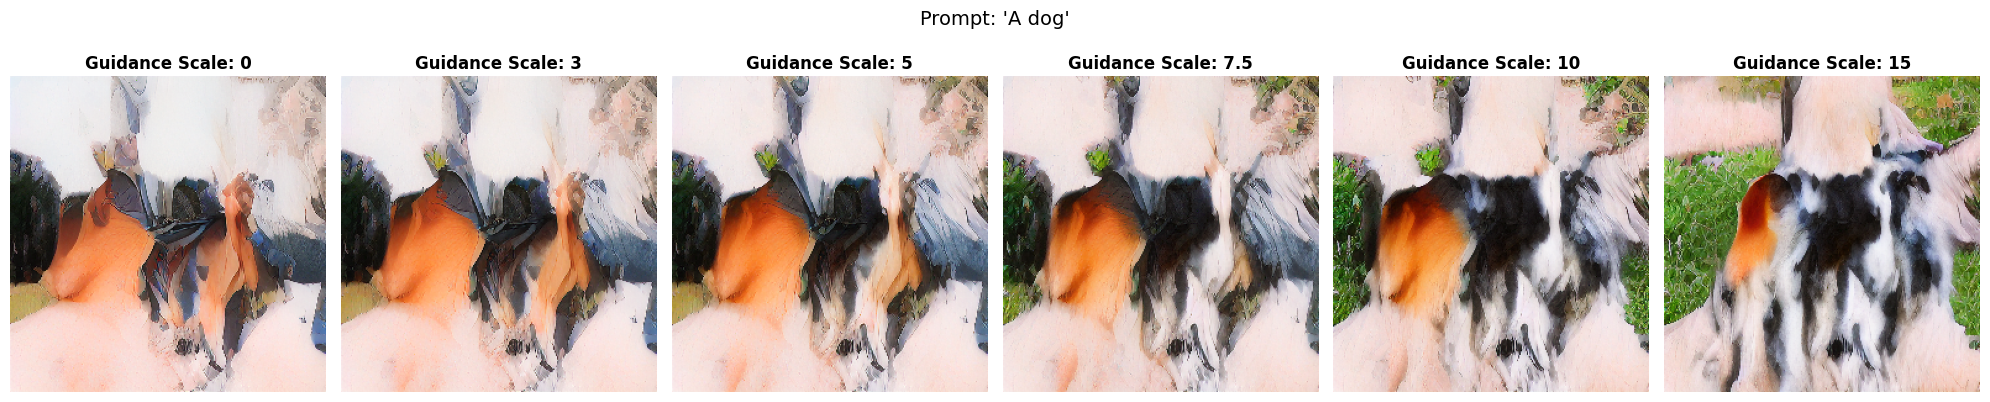

In [9]:
# Display all images in a row
fig, axes = plt.subplots(1, len(guidance_scales), figsize=(20, 4))

for ax, image, gs in zip(axes, generated_images, guidance_scales):
    img = image[0].permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.set_title(f"Guidance Scale: {gs}", fontsize=12, fontweight='bold')
    ax.axis('off')

plt.suptitle(f"Prompt: '{prompt}'", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 9. Save Images

In [10]:
from torchvision.utils import save_image

# Create output directory
output_dir = "./inference_outputs"
os.makedirs(output_dir, exist_ok=True)

# Save individual images
for i, (image, gs) in enumerate(zip(generated_images, guidance_scales)):
    filename = f"guidance_{gs}.png"
    filepath = os.path.join(output_dir, filename)
    save_image(image, filepath)
    print(f"Saved: {filepath}")

# Save comparison grid
grid_path = os.path.join(output_dir, "comparison_grid.png")
fig.savefig(grid_path, dpi=150, bbox_inches='tight')
print(f"\nSaved comparison grid: {grid_path}")

print(f"\n✅ All images saved to {output_dir}")

Saved: ./inference_outputs/guidance_0.png
Saved: ./inference_outputs/guidance_3.png
Saved: ./inference_outputs/guidance_5.png
Saved: ./inference_outputs/guidance_7.5.png
Saved: ./inference_outputs/guidance_10.png
Saved: ./inference_outputs/guidance_15.png

Saved comparison grid: ./inference_outputs/comparison_grid.png

✅ All images saved to ./inference_outputs


## 10. Generate Another Image (Optional)

Run this cell to quickly generate another image with a different prompt or settings.

Generating: 'A cat sitting on a windowsill watching birds'


Generating (guidance=7.5): 100%|██████████| 50/50 [00:02<00:00, 21.67it/s]


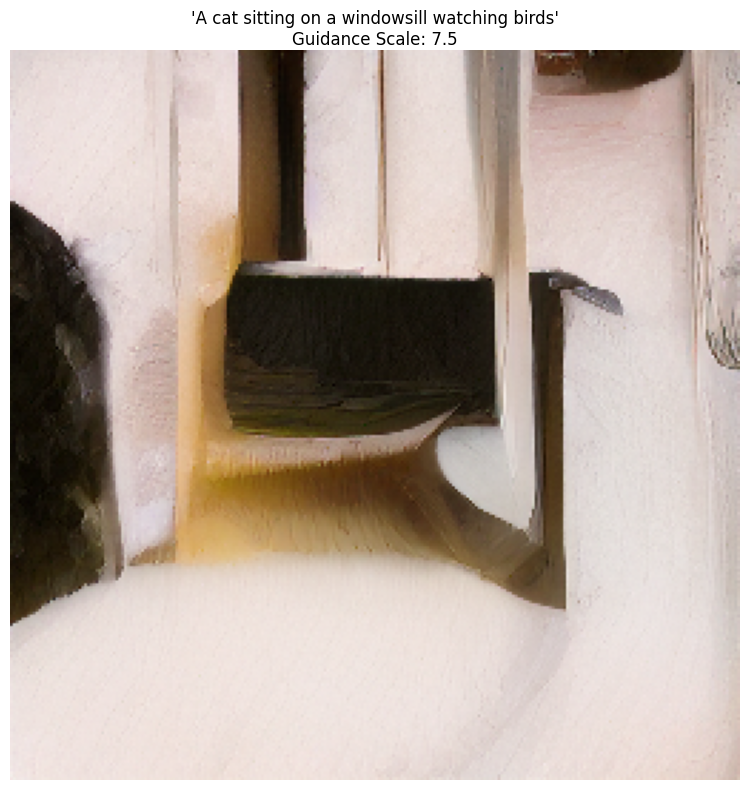

Saved: ./inference_outputs/custom_generation.png


In [11]:
# Quick generation with custom settings
custom_prompt = "A cat sitting on a windowsill watching birds"
custom_guidance = 7.5

print(f"Generating: '{custom_prompt}'")
image = generate_image(
    prompt=custom_prompt,
    guidance_scale=custom_guidance,
    num_inference_steps=50,
    seed=42,
)

# Display
plt.figure(figsize=(8, 8))
img = image[0].permute(1, 2, 0).numpy()
plt.imshow(img)
plt.title(f"'{custom_prompt}'\nGuidance Scale: {custom_guidance}", fontsize=12, wrap=True)
plt.axis('off')
plt.tight_layout()
plt.show()

# Save
save_path = os.path.join(output_dir, "custom_generation.png")
save_image(image, save_path)
print(f"Saved: {save_path}")

## Notes on Guidance Scale

- **0**: No guidance (unconditional generation, ignores prompt)
- **1-3**: Weak guidance (more creative, less adherence to prompt)
- **5-7.5**: Moderate guidance (balanced between creativity and prompt adherence) ✅ **Recommended**
- **10-15**: Strong guidance (strict adherence to prompt, may reduce diversity)
- **>15**: Very strong guidance (may produce artifacts or overfitting)

The optimal guidance scale depends on your specific use case and the complexity of the prompt.